# SOM Regressor - Hyperspectral soil-moisture dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import susi

## Data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/felixriese/hyperspectral-soilmoisture-dataset/master/soilmoisture_dataset.csv")

In [3]:
# get hyperspectral bands:
hypbands = []
for col in df.columns:
    try:
        int(col)
    except Exception:
        continue
    hypbands.append(col)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df[hypbands], df["soil_moisture"],
    test_size=0.5, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 125) (340, 125) (339,) (340,)


## Regression

In [4]:
som = susi.SOMRegressor(
    n_rows=35,
    n_columns=35,
    n_iter_unsupervised=2500,
    n_iter_supervised=2500,
    neighborhood_mode_unsupervised="linear",
    neighborhood_mode_supervised="linear",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.5,
    learning_rate_end=0.05,
    # do_class_weighting=True,
    random_state=None,
    n_jobs=1)

In [5]:
som.fit(X_train, y_train)
pickle.dump(som, open("pickles/SOMRegressor.p", "wb"))

In [6]:
som = pickle.load(open("pickles/SOMRegressor.p", "rb"))
y_pred = som.predict(X_test)
y_pred_train = som.predict(X_train)
pickle.dump(y_pred, open("pickles/SOMRegressor_pred.p", "wb"))

In [7]:
print("Train:", r2_score(y_train, y_pred_train))
print("Test:", r2_score(y_test, y_pred))

Train: 0.8990352912146329
Test: 0.9019469162404402


## Plots

In [8]:
estimation_map = np.squeeze(som.get_estimation_map())
# print(estimation_map)

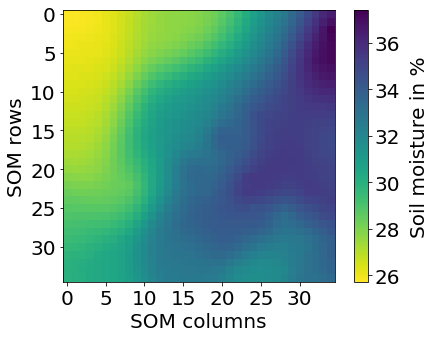

In [16]:
def plot_estimation_map(estimation_map, fontsize=20):
    plt.figure(figsize=(7,5))
    plt.imshow(estimation_map, cmap="viridis_r")
    plt.xlabel("SOM columns", fontsize=fontsize)
    plt.ylabel("SOM rows", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.set_ylabel('Soil moisture in %', fontsize=fontsize, labelpad=10)
    for label in cbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    plt.grid(b=False)
    plt.savefig("plots/regression_output_distribution.pdf", bbox_inches='tight')

plot_estimation_map(estimation_map)

In [21]:
def plot_som_histogram(bmu_list, n_rows, n_columns, fontsize=22):
    """Plot 2D Histogram of SOM.

    Plot 2D Histogram with one bin for each SOM node. The content of one
    bin is the number of datapoints matched to the specific node.

    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # colormap
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

    #bounds = np.linspace(0, 5, 6)
    bounds = np.arange(0.,6.,1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ax2 = fig.add_axes([0.96, 0.12, 0.03, 0.76])
    cbar = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', extend="max")
    cbar.ax.set_ylabel('Number of datapoints', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    counts, xedges, yedges, Image = ax.hist2d(
        [x[0] for x in bmu_list], [x[1] for x in bmu_list],
        bins=[n_rows, n_columns], cmin=1, cmap=cmap, norm=norm)

    #print(np.nanmax(counts))
    
    for label in cbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    # plt.xlim(xmin=0, xmax=self.NColumns)
    # plt.ylim(ymin=0, ymax=self.NRows)
    ax.set_xlabel("SOM columns", fontsize=fontsize)
    ax.set_ylabel("SOM rows", fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    # to be compatible with plt.imshow:
    ax.invert_yaxis()

    plt.grid(b=False)
    plt.savefig("plots/regression_som_histogram.pdf", bbox_inches='tight')

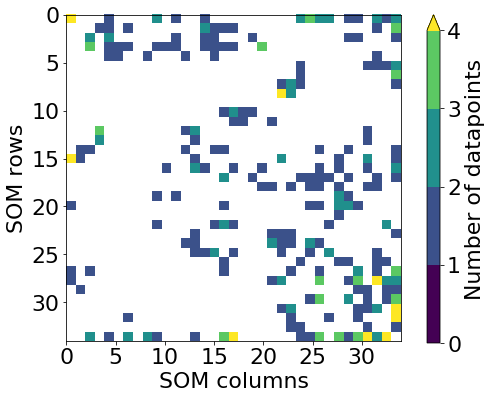

In [22]:
bmu_list = som.get_bmus(X_train.values, som.unsuper_som_)
plot_som_histogram(bmu_list, 35, 35)

## Random Forest

In [6]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [7]:
y_pred_rf = model.predict(X_test)
y_pred_train_rf = model.predict(X_train)

In [8]:
print("Train:", r2_score(y_train, y_pred_train_rf))
print("Test:", r2_score(y_test, y_pred_rf))

Train: 0.9919601451355625
Test: 0.9354865027540096
